In [1]:
import tensorflow as tf
import matplotlib.pylab as plt
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import layers

In [2]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

In [3]:
import numpy as np
import PIL.Image as Image

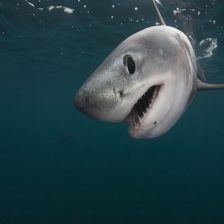

In [4]:
shark = tf.keras.utils.get_file('image.jpg','https://files.worldwildlife.org/wwfcmsprod/images/Shark_Porbeagle_GPN257609_Species/story_full_width/94u14y0rmw_GPN257609_porbeagle_shark.jpg')
shark = Image.open(shark).resize((IMAGE_RES, IMAGE_RES))
shark 

In [5]:
shark = np.array(shark)/255.0
shark.shape

(224, 224, 3)

In [6]:
result = model.predict(shark[np.newaxis,...])
result.shape

(1, 1001)

In [7]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

4

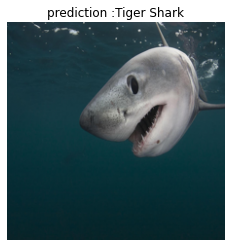

In [8]:
lable_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(lable_path).read().splitlines())

plt.imshow(shark)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_= plt.title('prediction :' + predicted_class_name.title())

In [9]:
# For tensorflow dataset cats vs dog
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(train_examples, validation_examples), info = tfds.load(
 'cats_vs_dogs',
  with_info=True,
  as_supervised=True,
  split=['train[:80%]', 'train[80%:]'],
    
)

#num_examples = info.split['train'].num_examples
#num_classes = info.features['labels'].num_classes

In [10]:
for i, example_image in enumerate(train_examples.take(3)):
    print('Image {} Shape: {}'.format(i+1, example_image[0].shape))

Image 1 Shape: (262, 350, 3)
Image 2 Shape: (409, 336, 3)
Image 3 Shape: (493, 500, 3)


In [11]:
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [12]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

batch_size = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(batch_size).prefetch(1)

In [13]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_name = imagenet_labels[np.argmax(result_batch,axis=-1)]
predicted_class_name

array(['lynx', 'Egyptian cat', 'tiger cat', 'tabby', 'Egyptian cat',
       'tiger cat', 'lynx', 'kelpie', 'Tibetan mastiff', 'dingo',
       'Siamese cat', 'chow', 'Egyptian cat', 'tabby', 'affenpinscher',
       'bluetick', 'German short-haired pointer', 'tabby', 'dingo',
       'Siamese cat', 'Egyptian cat', 'skunk', 'malamute', 'Egyptian cat',
       'miniature poodle', 'English setter', 'Labrador retriever',
       'affenpinscher', 'quilt', 'Rhodesian ridgeback', 'hamper',
       'Egyptian cat'], dtype='<U30')

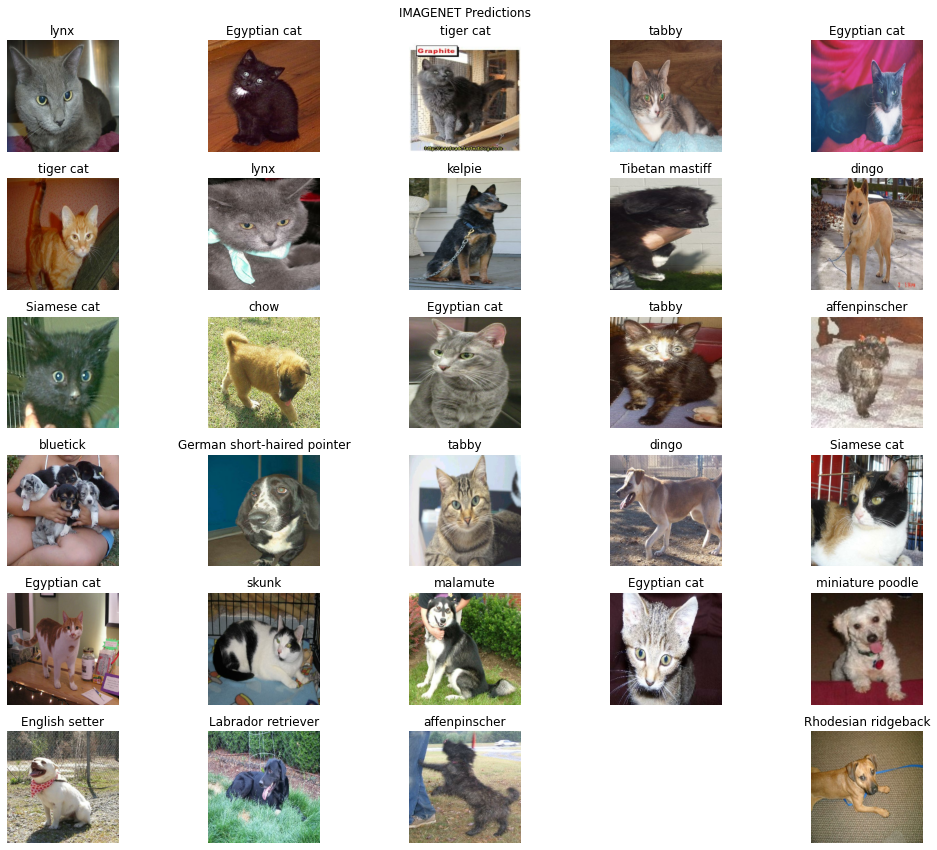

In [16]:

plt.figure(figsize=(15,12))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_name[n])
    plt.axis('off')
    plt.tight_layout()
    _ = plt.suptitle("IMAGENET Predictions")

In [17]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extracter = hub.KerasLayer(URL, input_shape=(IMAGE_RES,IMAGE_RES,3))

In [18]:
feature_batch = feature_extracter(image_batch)
print(feature_batch.shape)

(32, 1280)


In [19]:
feature_extracter.trainable = False

In [21]:
model = tf.keras.Sequential([
    feature_extracter,
    layers.Dense(2)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
model.compile(optimizer='adam',
             loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [24]:
epochs = 2
history = model.fit(train_batches,
                   epochs=epochs,
                   validation_data=validation_batches)

Epoch 1/2
582/582 [==============================] - 420s 718ms/step - loss: 0.0414 - accuracy: 0.9863 - val_loss: 0.0381 - val_accuracy: 0.9862
Epoch 2/2
582/582 [==============================] - 399s 678ms/step - loss: 0.0301 - accuracy: 0.9896 - val_loss: 0.0294 - val_accuracy: 0.9912


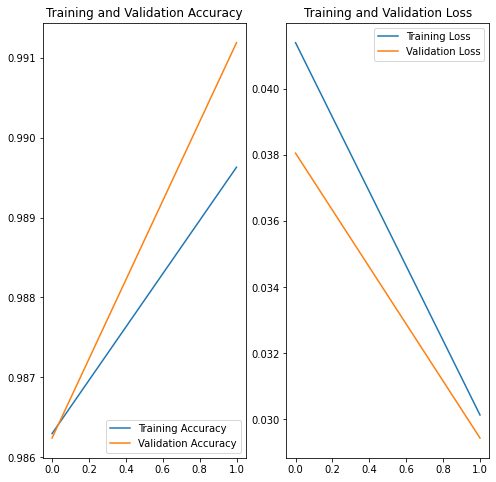

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [31]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_name = class_names[predicted_ids]
predicted_class_name

array(['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog',
       'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat',
       'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog',
       'dog', 'cat', 'dog', 'cat', 'cat'], dtype='<U3')

In [32]:
print('labels :', label_batch)
print('predicted labels', predicted_ids)

labels : [0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0 0]
predicted labels [0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0 0]


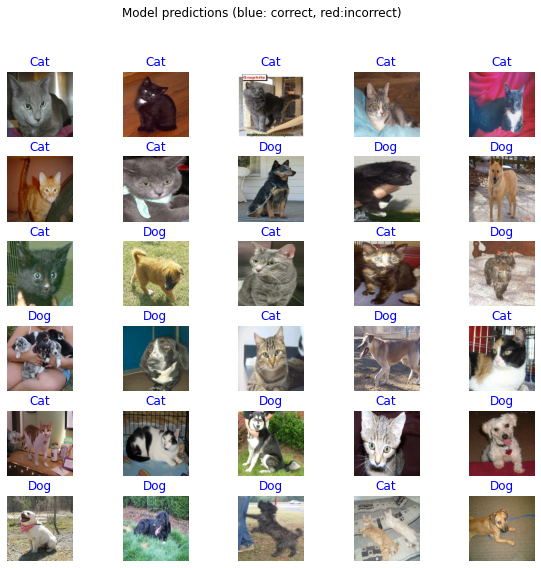

In [40]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = 'blue' if predicted_ids[n] == label_batch[n] else 'red'
   plt.title(predicted_class_names[n].title(), color=color)
   plt.axis('off')
_= plt.suptitle('Model predictions (blue: correct, red:incorrect)')  

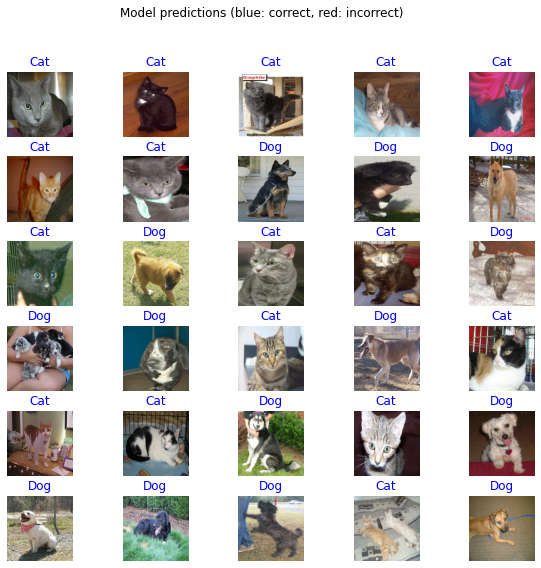

In [36]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")